# Fraud Detection

## Data Analysis

In [1]:
import glob
import pandas as pd
import numpy as np

input_filenames = sorted(glob.glob('fraud_detection/*.Inputs'))
target_filenames = sorted(glob.glob('fraud_detection/*.Targets'))

df = pd.DataFrame()
for input_file, target_file in zip(input_filenames, target_filenames):
    df = df.append(pd.read_csv(input_file))
    df['fraud'] = pd.read_csv(target_file)

df = df.reset_index(drop=True)
df.head()

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,amount,domain1,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,fraud,hour1,hour2,indicator1,indicator2,state1,total,zip1
0,25.90,BELLSOUTH.NET,3,1,3878,8,0,1,0,1,0,1,0.0,0,0,0,0,FL,25.90,331
1,38.85,COMCAST.NET,2,1,-6330,21,1,0,1,1,0,1,0.0,0,0,0,0,TX,38.85,750
2,38.85,HOTMAIL.COM,2,0,5183,19,1,0,0,0,0,1,0.0,1,1,0,0,VA,38.85,222
3,24.95,GMAIL.COM,0,0,3822,16,0,0,0,0,0,1,0.0,1,1,0,0,CA,24.95,946
4,20.72,LEVEL3.COM,3,0,3536,8,1,1,1,1,0,1,0.0,1,1,0,0,CO,20.72,805


In [2]:
df['fraud'].value_counts()

0.0    926862
1.0     19950
Name: fraud, dtype: int64

### Dataset Profiling Report

In [3]:
# import pandas_profiling

# profile = pandas_profiling.ProfileReport(df)
# profile.to_file(output_file="ProfilingResult.html")

In [4]:
# profile

### Rows containing null values

In [5]:
df[pd.isnull(df).any(axis=1)]

,amount,domain1,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,fraud,hour1,hour2,indicator1,indicator2,state1,total,zip1
72844,38.85,NaN,3,0,-2459,38,24,0,1,1,0,0,0.0,16,16,0,0,NY,38.85,105
101673,38.85,NaN,3,0,-2459,38,24,0,1,1,0,0,0.0,16,16,0,0,NY,38.85,105
189363,38.85,AOL.COM,2,0,-676,8,2,0,1,1,0,4,NaN,19,19,0,0,AZ,38.85,857
262125,38.85,NaN,3,0,-2459,38,24,0,1,1,0,0,0.0,16,16,0,0,NY,38.85,105
356831,38.85,NaN,3,0,-2459,38,24,0,1,1,0,0,0.0,16,16,0,0,NY,38.85,105
378727,38.85,AOL.COM,2,0,-676,8,2,0,1,1,0,4,NaN,19,19,0,0,AZ,38.85,857
451554,38.85,NaN,3,0,-2459,38,24,0,1,1,0,0,0.0,16,16,0,0,NY,38.85,105
473409,38.85,AOL.COM,2,0,-676,8,2,0,1,1,0,4,NaN,19,19,0,0,AZ,38.85,857
546180,38.85,NaN,3,0,-2459,38,24,0,1,1,0,0,0.0,16,16,0,0,NY,38.85,105
568091,38.85,AOL.COM,2,0,-676,8,2,0,1,1,0,4,NaN,19,19,0,0,AZ,38.85,857


## Data Preprocessing

Drop highly correlated columns

In [6]:
clean_df = df.drop(columns=['hour2', 'domain1', 'total'])
clean_df.head()

,amount,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,fraud,hour1,indicator1,indicator2,state1,zip1
0,25.90,3,1,3878,8,0,1,0,1,0,1,0.0,0,0,0,FL,331
1,38.85,2,1,-6330,21,1,0,1,1,0,1,0.0,0,0,0,TX,750
2,38.85,2,0,5183,19,1,0,0,0,0,1,0.0,1,0,0,VA,222
3,24.95,0,0,3822,16,0,0,0,0,0,1,0.0,1,0,0,CA,946
4,20.72,3,0,3536,8,1,1,1,1,0,1,0.0,1,0,0,CO,805


In [7]:
clean_df = clean_df.dropna()
clean_df = clean_df.drop_duplicates()

In [8]:
clean_df['state1'] = clean_df['state1'].astype('category')
clean_df['state1'] = clean_df['state1'].cat.codes

clean_df.head()

,amount,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,fraud,hour1,indicator1,indicator2,state1,zip1
0,25.90,3,1,3878,8,0,1,0,1,0,1,0.0,0,0,0,11,331
1,38.85,2,1,-6330,21,1,0,1,1,0,1,0.0,0,0,0,45,750
2,38.85,2,0,5183,19,1,0,0,0,0,1,0.0,1,0,0,47,222
3,24.95,0,0,3822,16,0,0,0,0,0,1,0.0,1,0,0,6,946
4,20.72,3,0,3536,8,1,1,1,1,0,1,0.0,1,0,0,7,805


In [9]:
clean_df.shape

(99305, 17)

In [10]:
clean_df.loc[55861]

amount           0.0
field1           4.0
field2           1.0
field3       -4216.0
field4          10.0
field5           0.0
flag1            0.0
flag2            1.0
flag3            1.0
flag4            0.0
flag5         1434.0
fraud            0.0
hour1           13.0
indicator1       0.0
indicator2       0.0
state1          20.0
zip1           708.0
Name: 55861, dtype: float64

## Split dataset

In [11]:
from sklearn.model_selection import train_test_split

X = clean_df.drop(columns=['fraud'])
y = clean_df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## Outlier Removed in Training Data

In [12]:
train_df = X_train
train_df['fraud'] = y_train
train_df

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,amount,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,hour1,indicator1,indicator2,state1,zip1,fraud
60436,10.36,3,0,-2897,7,0,1,0,0,0,2,13,0,0,6,926,0.0
26136,39.96,2,0,2763,8,0,0,1,0,0,1,12,1,0,12,303,0.0
47342,11.01,2,0,5988,12,3,1,1,1,0,1,17,1,0,35,890,0.0
92074,14.95,3,1,2922,23,0,1,0,0,0,1,15,0,0,33,80,0.0
29862,12.95,2,0,3034,10,2,0,1,0,0,1,12,0,0,50,532,0.0
154647,38.85,3,1,2793,10,4,1,0,0,0,2,0,1,0,6,911,1.0
24330,38.85,3,0,-1187,20,0,0,0,0,0,1,15,0,0,18,678,0.0
198770,12.95,2,0,-6403,10,0,0,0,0,0,2,19,0,0,4,722,0.0
34249,38.85,3,1,-5248,10,7,1,0,0,0,1,8,0,0,11,334,0.0
84767,38.85,2,0,3962,6,0,1,1,0,0,1,15,0,0,37,441,0.0


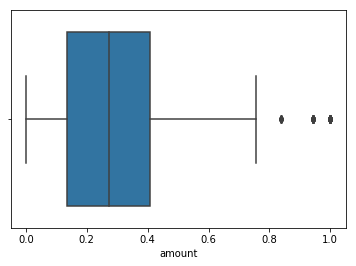

In [45]:
import seaborn as sns

# Same as using IQR guys
sns.boxplot(x=train_df['amount'])

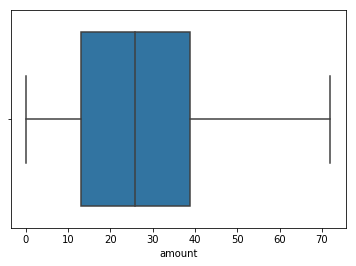

In [14]:
Q1 = train_df['amount'].quantile(0.25)
Q3 = train_df['amount'].quantile(0.75)
IQR = Q3 - Q1

outlier_removed_df = train_df
outlier_df = train_df
filter = (outlier_removed_df['amount'] >= Q1 - 1.5 * IQR) & (outlier_removed_df['amount'] <= Q3 + 1.5 *IQR)
outlier_filter = (outlier_removed_df['amount'] < Q1 - 1.5 * IQR) | (outlier_removed_df['amount'] > Q3 + 1.5 *IQR)
outlier_df = outlier_df.loc[outlier_filter]
outlier_removed_df = outlier_removed_df.loc[filter]

sns.boxplot(x=outlier_removed_df['amount'])

In [15]:
outlier_df['fraud'].value_counts()

0.0    38
1.0    19
Name: fraud, dtype: int64

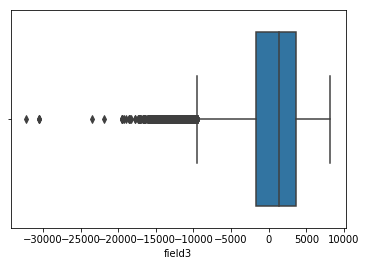

In [16]:
# Same as using IQR guys
sns.boxplot(x=outlier_removed_df['field3'])

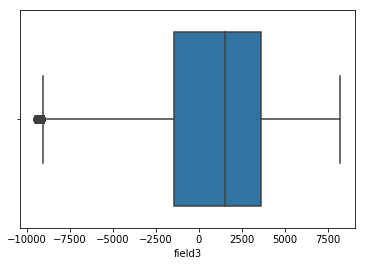

In [17]:
Q1 = outlier_removed_df['field3'].quantile(0.25)
Q3 = outlier_removed_df['field3'].quantile(0.75)
IQR = Q3 - Q1

outlier_removed_df = train_df
outlier_df = train_df
filter = (outlier_removed_df['field3'] >= Q1 - 1.5 * IQR) & (outlier_removed_df['field3'] <= Q3 + 1.5 *IQR)
outlier_filter = (outlier_removed_df['field3'] < Q1 - 1.5 * IQR) | (outlier_removed_df['field3'] > Q3 + 1.5 *IQR)
outlier_df = outlier_df.loc[outlier_filter]
outlier_removed_df = outlier_removed_df.loc[filter] 

sns.boxplot(x=outlier_removed_df['field3'])

In [18]:
outlier_df['fraud'].value_counts()

0.0    978
1.0    159
Name: fraud, dtype: int64

## MinMax Scaling Some Features

In [19]:
from sklearn.preprocessing import minmax_scale

min_max_scale_columns = ['amount', 'field3', 'field4', 'field5', 'flag5', 'hour1', 'zip1']

for col in min_max_scale_columns :
    outlier_removed_df[col] = minmax_scale(outlier_removed_df[col])
    X_test[col] = minmax_scale(X_test[col])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

In [20]:
train_df = outlier_removed_df
outlier_removed_df.shape

(73341, 17)

In [21]:
train_df.head()

,amount,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,hour1,indicator1,indicator2,state1,zip1,fraud
60436,0.108595,3,0,0.374153,0.027778,0.000000,1,0,0,0,0.000610,0.565217,0,0,6,0.926780,0.0
26136,0.418868,2,0,0.693567,0.055556,0.000000,0,1,0,0,0.000305,0.521739,1,0,12,0.301906,0.0
47342,0.115409,2,0,0.875564,0.166667,0.115385,1,1,1,0,0.000305,0.739130,1,0,35,0.890672,0.0
92074,0.156709,3,1,0.702540,0.472222,0.000000,1,0,0,0,0.000305,0.652174,0,0,33,0.078235,0.0
29862,0.135744,2,0,0.708860,0.111111,0.076923,0,1,0,0,0.000305,0.521739,0,0,50,0.531595,0.0


In [22]:
X_test.head()

,amount,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,hour1,indicator1,indicator2,state1,zip1
65822,0.407233,3,1,0.787946,0.300,0.076923,0,1,0,0,0.000305,0.565217,0,0,22,0.207623
43331,0.407233,3,0,0.658271,0.050,0.038462,1,1,1,0,0.000610,0.521739,0,0,37,0.439318
301479,0.407233,2,0,0.445816,0.025,0.115385,0,1,1,0,0.000305,0.304348,0,0,16,0.599799
31453,0.271488,2,0,0.623420,0.050,0.115385,1,1,1,0,0.000305,0.608696,0,0,45,0.760281
41288,0.407233,3,1,0.907051,0.375,0.000000,0,1,1,0,0.000610,0.478261,0,1,40,0.167503


## Oversampling & Undersampling

In [23]:
X_train = train_df.drop(columns=['fraud'])
y_train = train_df['fraud']

### Oversampling Approach

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_train_oversampling = X_train
y_train_oversampling = y_train
X_res, y_res = smote.fit_resample(X_train_oversampling, y_train_oversampling)

dataset_res = []
for i in range(len(y_res)):
    dataset_res.append(np.append(X_res[i], y_res[i]))

dataset_res = np.asarray(dataset_res)
dataset_res.shape
dataset_res

Using TensorFlow backend.


array([[ 0.10859539,  3.        ,  0.        , ...,  6.        ,
         0.92678034,  0.        ],
       [ 0.41886792,  2.        ,  0.        , ..., 12.        ,
         0.30190572,  0.        ],
       [ 0.11540881,  2.        ,  0.        , ..., 35.        ,
         0.89067202,  0.        ],
       ...,
       [ 0.4072327 ,  4.        ,  0.        , ...,  6.        ,
         0.92362464,  1.        ],
       [ 0.13574423,  0.        ,  1.        , ..., 40.        ,
         0.18787329,  1.        ],
       [ 0.4072327 ,  3.        ,  0.        , ...,  6.        ,
         0.92183921,  1.        ]])

In [25]:
# dataset_res[0]

In [26]:
columns = X.columns.tolist()
columns.append('fraud')

oversampled_df = pd.DataFrame(dataset_res, columns=columns)
oversampled_df

,amount,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,hour1,indicator1,indicator2,state1,zip1,fraud
0,0.108595,3.000000,0.000000,0.374153,0.027778,0.000000,1.000000,0.000000,0.000000,0.000000,0.000610,0.565217,0.000000,0.0,6.000000,0.926780,0.0
1,0.418868,2.000000,0.000000,0.693567,0.055556,0.000000,0.000000,1.000000,0.000000,0.000000,0.000305,0.521739,1.000000,0.0,12.000000,0.301906,0.0
2,0.115409,2.000000,0.000000,0.875564,0.166667,0.115385,1.000000,1.000000,1.000000,0.000000,0.000305,0.739130,1.000000,0.0,35.000000,0.890672,0.0
3,0.156709,3.000000,1.000000,0.702540,0.472222,0.000000,1.000000,0.000000,0.000000,0.000000,0.000305,0.652174,0.000000,0.0,33.000000,0.078235,0.0
4,0.135744,2.000000,0.000000,0.708860,0.111111,0.076923,0.000000,1.000000,0.000000,0.000000,0.000305,0.521739,0.000000,0.0,50.000000,0.531595,0.0
5,0.407233,3.000000,1.000000,0.695260,0.111111,0.153846,1.000000,0.000000,0.000000,0.000000,0.000610,0.000000,1.000000,0.0,6.000000,0.911735,1.0
6,0.407233,3.000000,0.000000,0.470655,0.388889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000305,0.652174,0.000000,0.0,18.000000,0.678034,0.0
7,0.135744,2.000000,0.000000,0.176298,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000610,0.826087,0.000000,0.0,4.000000,0.722166,0.0
8,0.407233,3.000000,1.000000,0.241479,0.111111,0.269231,1.000000,0.000000,0.000000,0.000000,0.000305,0.347826,0.000000,0.0,11.000000,0.332999,0.0
9,0.407233,2.000000,0.000000,0.761230,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000305,0.652174,0.000000,0.0,37.000000,0.440321,0.0


In [27]:
# import pandas_profiling

# profile = pandas_profiling.ProfileReport(oversampled_df)
# profile.to_file(output_file="OversampledProfilingResult.html")

In [28]:
oversampled_df['fraud'].value_counts()

1.0    64517
0.0    64517
Name: fraud, dtype: int64

### Undersampling Approach

In [29]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours 
from sklearn.datasets import make_classification
from collections import Counter

X_train_undersampling = X_train
y_train_undersampling = y_train
# print (y_train_undersampling)
print (X_train_undersampling.shape)

renn = RepeatedEditedNearestNeighbours(sampling_strategy='majority')
X_res, y_res = renn.fit_resample(X_train_undersampling, y_train_undersampling)
# print (y)
print (X_res.shape)

(73341, 16)
(44482, 16)


In [30]:
dataset_res = []
for i in range(len(y_res)):
    dataset_res.append(np.append(X_res[i], y_res[i]))

dataset_res = np.asarray(dataset_res)

undersampled_df = pd.DataFrame(dataset_res, columns=columns)
undersampled_df

,amount,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,hour1,indicator1,indicator2,state1,zip1,fraud
0,0.418868,2.0,0.0,0.693567,0.055556,0.000000,0.0,1.0,0.0,0.0,0.000305,0.521739,1.0,0.0,12.0,0.301906,0.0
1,0.115409,2.0,0.0,0.875564,0.166667,0.115385,1.0,1.0,1.0,0.0,0.000305,0.739130,1.0,0.0,35.0,0.890672,0.0
2,0.156709,3.0,1.0,0.702540,0.472222,0.000000,1.0,0.0,0.0,0.0,0.000305,0.652174,0.0,0.0,33.0,0.078235,0.0
3,0.135744,2.0,0.0,0.708860,0.111111,0.076923,0.0,1.0,0.0,0.0,0.000305,0.521739,0.0,0.0,50.0,0.531595,0.0
4,0.407233,3.0,0.0,0.470655,0.388889,0.000000,0.0,0.0,0.0,0.0,0.000305,0.652174,0.0,0.0,18.0,0.678034,0.0
5,0.407233,3.0,1.0,0.241479,0.111111,0.269231,1.0,0.0,0.0,0.0,0.000305,0.347826,0.0,0.0,11.0,0.332999,0.0
6,0.407233,2.0,0.0,0.761230,0.000000,0.000000,1.0,1.0,0.0,0.0,0.000305,0.652174,0.0,0.0,37.0,0.440321,0.0
7,0.523585,2.0,0.0,0.198533,0.083333,0.000000,1.0,1.0,1.0,0.0,0.000305,0.391304,0.0,0.0,47.0,0.224674,0.0
8,0.523585,3.0,1.0,0.633239,0.416667,0.000000,0.0,1.0,1.0,0.0,0.000305,0.565217,0.0,0.0,6.0,0.921765,0.0
9,0.407233,3.0,1.0,0.459537,0.333333,0.192308,1.0,1.0,1.0,0.0,0.000305,0.565217,0.0,0.0,33.0,0.071214,0.0


In [31]:
undersampled_df['fraud'].value_counts()

0.0    35658
1.0     8824
Name: fraud, dtype: int64

In [32]:
y_train.value_counts()

0.0    64517
1.0     8824
Name: fraud, dtype: int64

### Hybrid Approach

In [33]:
from imblearn.combine import SMOTEENN

X_train_combine = X_train
y_train_combine = y_train

print (X_train_combine.shape)

sme = SMOTEENN(sampling_strategy='minority', ratio=0.85)
X_res, y_res = sme.fit_resample(X_train_combine, y_train_combine)

print (X_res.shape)

(73341, 16)
(64492, 16)


In [34]:
dataset_res = []
for i in range(len(y_res)):
    dataset_res.append(np.append(X_res[i], y_res[i]))

dataset_res = np.asarray(dataset_res)

combined_df = pd.DataFrame(dataset_res, columns=columns)
combined_df

,amount,field1,field2,field3,field4,field5,flag1,flag2,flag3,flag4,flag5,hour1,indicator1,indicator2,state1,zip1,fraud
0,0.418868,2.000000,0.0,0.693567,0.055556,0.000000,0.000000,1.00000,0.000000,0.0,0.000305,0.521739,1.000000,0.000000,12.000000,0.301906,0.0
1,0.115409,2.000000,0.0,0.875564,0.166667,0.115385,1.000000,1.00000,1.000000,0.0,0.000305,0.739130,1.000000,0.000000,35.000000,0.890672,0.0
2,0.156709,3.000000,1.0,0.702540,0.472222,0.000000,1.000000,0.00000,0.000000,0.0,0.000305,0.652174,0.000000,0.000000,33.000000,0.078235,0.0
3,0.135744,2.000000,0.0,0.708860,0.111111,0.076923,0.000000,1.00000,0.000000,0.0,0.000305,0.521739,0.000000,0.000000,50.000000,0.531595,0.0
4,0.407233,3.000000,0.0,0.470655,0.388889,0.000000,0.000000,0.00000,0.000000,0.0,0.000305,0.652174,0.000000,0.000000,18.000000,0.678034,0.0
5,0.407233,3.000000,1.0,0.241479,0.111111,0.269231,1.000000,0.00000,0.000000,0.0,0.000305,0.347826,0.000000,0.000000,11.000000,0.332999,0.0
6,0.407233,2.000000,0.0,0.761230,0.000000,0.000000,1.000000,1.00000,0.000000,0.0,0.000305,0.652174,0.000000,0.000000,37.000000,0.440321,0.0
7,0.523585,2.000000,0.0,0.198533,0.083333,0.000000,1.000000,1.00000,1.000000,0.0,0.000305,0.391304,0.000000,0.000000,47.000000,0.224674,0.0
8,0.523585,3.000000,1.0,0.633239,0.416667,0.000000,0.000000,1.00000,1.000000,0.0,0.000305,0.565217,0.000000,0.000000,6.000000,0.921765,0.0
9,0.135744,3.000000,1.0,0.279345,0.027778,0.000000,1.000000,0.00000,0.000000,0.0,0.000305,0.869565,0.000000,0.000000,22.000000,0.206620,0.0


In [35]:
combined_df['fraud'].value_counts()

0.0    36944
1.0    27548
Name: fraud, dtype: int64

## Model and Evaluation

In [36]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score

# X = oversampled_df.drop(columns=['fraud']).to_numpy()
# y = oversampled_df['fraud']

# model = MultinomialNB(alpha=1e-10)

# kf = StratifiedKFold(n_splits=10)
# for train_index, test_index in kf.split(X, y):
#     X_train_model, X_validation_model = X[train_index], X[test_index]
#     y_train_model, y_validation_model = y[train_index], y[test_index]
#     model.fit(X_train_model, y_train_model)
#     predict = model.predict(X_validation_model)
#     print ("Accuracy\t", accuracy_score(y_validation_model, predict))

In [37]:
# def show_history(history):
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()
#     # summarize history for loss
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()

In [38]:
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from keras.regularizers import l2

X = combined_df.drop(columns=['fraud']).to_numpy()
y = combined_df['fraud']

model = Sequential()
model.add(Dense(10, input_dim=16, kernel_initializer='normal', activation='relu'))
model.add(Dense(5, kernel_initializer='normal', activation='relu'))
model.add(Dense(2, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy', 'mae'])

# model = Sequential()
# model.add(Dense(10, input_dim=16, kernel_initializer='normal', activation='relu'))
# model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy', 'mae'])

kf = StratifiedKFold(n_splits=3)
for train_index, test_index in kf.split(X, y):
    X_train_model, X_validation_model = X[train_index], X[test_index]
    y_train_model, y_validation_model = y[train_index], y[test_index]
    history = model.fit(X_train_model, y_train_model, epochs=20, batch_size=100,  verbose=1)
    predict = model.predict_classes(X_validation_model)
    print ("Accuracy\t", accuracy_score(y_validation_model, predict))
    print ("Precision\t", precision_score(y_validation_model, predict, average='binary'))
    print ("Recall\t\t", recall_score(y_validation_model, predict, average='binary'))
    print ("F1 Score\t", f1_score(y_validation_model, predict, average='binary'))
    print(classification_report(y_validation_model, predict, target_names=['0', '1']))

Epoch 1/20
42994/42994 [==============================] - 1s 18us/step - loss: 0.2425 - accuracy: 0.5728 - mae: 0.4878
Epoch 2/20
42994/42994 [==============================] - 1s 15us/step - loss: 0.2129 - accuracy: 0.6800 - mae: 0.4330
Epoch 3/20
42994/42994 [==============================] - 1s 13us/step - loss: 0.2023 - accuracy: 0.7014 - mae: 0.4075
Epoch 4/20
42994/42994 [==============================] - 1s 15us/step - loss: 0.2013 - accuracy: 0.7007 - mae: 0.4039
Epoch 5/20
42994/42994 [==============================] - 1s 15us/step - loss: 0.2008 - accuracy: 0.7001 - mae: 0.4024
Epoch 6/20
42994/42994 [==============================] - 1s 16us/step - loss: 0.2001 - accuracy: 0.7035 - mae: 0.4008
Epoch 7/20
42994/42994 [==============================] - 1s 17us/step - loss: 0.2002 - accuracy: 0.7030 - mae: 0.4002
Epoch 8/20
42994/42994 [==============================] - 1s 16us/step - loss: 0.2000 - accuracy: 0.7018 - mae: 0.3999
Epoch 9/20
42994/42994 [========================

In [39]:
from sklearn.metrics import classification_report

predict_test = model.predict_classes(X_test)
print ("Accuracy\t\t", accuracy_score(y_test, predict_test))
print ("Precision binary avg\t", precision_score(y_test, predict_test, average='binary'))
print ("Recall binary avg\t", recall_score(y_test, predict_test, average='binary'))
print ("F1 Score binary avg\t", f1_score(y_test, predict_test, average='binary'))

print(classification_report(y_test, predict_test, target_names=['0', '1']))

Accuracy		 0.7497885366737825
Precision binary avg	 0.25760771316661646
Recall binary avg	 0.5711422845691383
F1 Score binary avg	 0.35506644518272423
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     21833
           1       0.26      0.57      0.36      2994

    accuracy                           0.75     24827
   macro avg       0.59      0.67      0.60     24827
weighted avg       0.85      0.75      0.79     24827



In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 240
Trainable params: 240
Non-trainable params: 0
_________________________________________________________________


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_fscore_support

print("Random Forest with hybrid data")
random_forest_clf_h = RandomForestClassifier(n_estimators = 250, max_depth=2, random_state=10, class_weight='balanced', bootstrap=False)
X_random_forest_h = combined_df.drop(columns=['fraud']).to_numpy()
y_random_forest_h = combined_df['fraud']

kf = StratifiedKFold(n_splits=3)
for train_index, test_index in kf.split(X_random_forest_h, y_random_forest_h):
    X_train_model, X_validation_model = X_random_forest_h[train_index], X_random_forest_h[test_index]
    y_train_model, y_validation_model = y_random_forest_h[train_index], y_random_forest_h[test_index]
    history = random_forest_clf_h.fit(X_train_model, y_train_model)
    predict = random_forest_clf_h.predict(X_validation_model)
    print ("Accuracy\t", accuracy_score(y_validation_model, predict))

Random Forest with hybrid data
Accuracy	 0.7673737091822496
Accuracy	 0.7674202251372221
Accuracy	 0.7678637886118348


In [43]:
predict_test = random_forest_clf_h.predict(X_test)
print ("Accuracy\t\t", accuracy_score(y_test, predict_test))
print ("Precision binary avg\t", precision_score(y_test, predict_test, average='binary'))
print ("Recall binary avg\t", recall_score(y_test, predict_test, average='binary'))
print ("F1 Score binary avg\t", f1_score(y_test, predict_test, average='binary'))

print(classification_report(y_test, predict_test, target_names=['0', '1']))

Accuracy		 0.7172836025295042
Precision binary avg	 0.24049000644745325
Recall binary avg	 0.6229124916499666
F1 Score binary avg	 0.3470090240952647
              precision    recall  f1-score   support

           0       0.93      0.73      0.82     21833
           1       0.24      0.62      0.35      2994

    accuracy                           0.72     24827
   macro avg       0.59      0.68      0.58     24827
weighted avg       0.85      0.72      0.76     24827



In [44]:
from sklearn import tree

X = combined_df.drop(columns=['fraud']).to_numpy()
y = combined_df['fraud']

clf = tree.DecisionTreeClassifier(max_depth=2)

kf = StratifiedKFold(n_splits=20)
for train_index, test_index in kf.split(X, y):
    X_train_model, X_validation_model = X[train_index], X[test_index]
    y_train_model, y_validation_model = y[train_index], y[test_index]
    history = clf.fit(X_train_model, y_train_model)
    predict = clf.predict(X_validation_model)
    print ("Accuracy\t", accuracy_score(y_validation_model, predict))
    print(classification_report(y_validation_model, predict, target_names=['0', '1']))

predict_test = clf.predict(X_test)
print ("Accuracy\t", accuracy_score(y_test, predict_test))
print ("Precision\t", precision_score(y_test, predict_test, average='binary'))
print ("Recall\t\t", recall_score(y_test, predict_test, average='binary'))
print ("F1 Score\t", f1_score(y_test, predict_test, average='binary'))
print(classification_report(y_test, predict_test, target_names=['0', '1']))

Accuracy	 0.7520148791072536
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1848
           1       0.74      0.65      0.69      1378

    accuracy                           0.75      3226
   macro avg       0.75      0.74      0.74      3226
weighted avg       0.75      0.75      0.75      3226

Accuracy	 0.7520148791072536
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1848
           1       0.74      0.65      0.69      1378

    accuracy                           0.75      3226
   macro avg       0.75      0.74      0.74      3226
weighted avg       0.75      0.75      0.75      3226

Accuracy	 0.7591444513329201
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1848
           1       0.75      0.66      0.70      1378

    accuracy                           0.76      3226
   macro avg       0.76      0.75      0.